In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).\
            first()
# converting the string into datetime
dt_latest_date = dt.datetime.strptime(latest_date.date, '%Y-%m-%d')
# Calculating the date from 12 months before
year_before = dt_latest_date - dt.timedelta(days=365) #20) #365)

# Perform a query to retrieve the data and precipitation scores
prcp_last12m = session.query(Measurement.date, Measurement.prcp).\
                filter( Measurement.date >= year_before).all()

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# --> reshape the list of tuples into a np.array
prcp_last12m_tab = np.reshape(prcp_last12m, (len(prcp_last12m),2))
# --> convert the np.array into a dataframe
df_prcp = pd.DataFrame(data=prcp_last12m_tab,
                       columns=['Date', 'Precipitations'])
# --> cast the columns into floats and datetime
df_prcp[['Precipitations']] = df_prcp[['Precipitations']].apply(pd.to_numeric)
df_prcp[['Date']] = df_prcp[['Date']].apply(pd.to_datetime)


# --> set the date column to index
df_prcp = df_prcp.set_index('Date')
df_prcp = df_prcp.dropna()

# Sort the dataframe by date
df_prcp.sort_values(by='Date')
df_prcp.head()
df_prcp.dtypes

Precipitations    float64
dtype: object

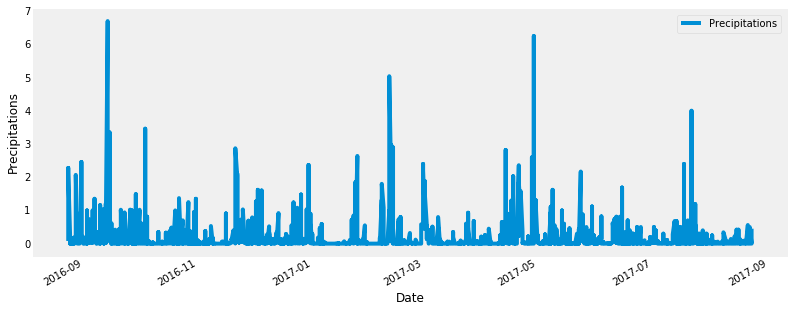

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=(12,5))
ax = df_prcp.plot(kind='line',  ax=ax)
plt.xticks()
plt.ylabel("Precipitations")
plt.xlabel("Date")
plt.grid(None)
plt.show()

# TODO: add xticks to the axis

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe(include='all')

,Precipitations
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# column of the Station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
nb_stations = session.query(Station.id).count()
print(f"There are {nb_stations} stations in this dataset.")

There are 9 stations in this dataset.


In [16]:
# columns of the Measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                                     group_by(Measurement.station).\
                                     order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station1_id = most_active_stations[0][0]
values = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == station1_id).first()
# we can use directly the tuple resulting from the query to make a pretty print
print(" Tmin: %.1f°\n Tmax: %.1f°\n Tavg: %.1f°"%(values))


 Tmin: 54.0°
 Tmax: 85.0°
 Tavg: 71.7°


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot 
# the results as a histogram
prcp_station1 = session.query(Measurement.tobs).\
                filter( Measurement.date >= year_before).\
                filter(Measurement.station == station1_id).all()
prcp_station1_r = np.ravel(prcp_station1)

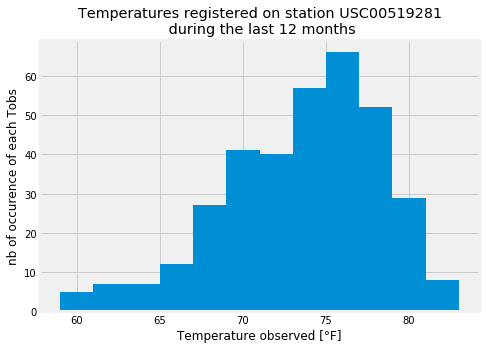

In [20]:
fig, ax = plt.subplots(figsize=(7,5))

plt.hist(prcp_station1_r, bins=12 )  #, bins=np.linspace(T[0], T[-1], 12))
plt.ylabel("nb of occurence of each Tobs")
plt.xlabel("Temperature observed [°F]")
plt.title(f"Temperatures registered on station {station1_id}\n during the last 12 months")
plt.show()

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = "2017-07-15"
trip_end = "2017-08-15"
trip_temps = calc_temps(trip_start, trip_end )
tmin = trip_temps[0][0]
tavg = trip_temps[0][1]
tmax = trip_temps[0][2]
[tmin,tmax]

[70.0, 84.0]

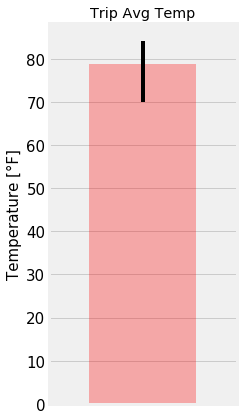

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,7))
plt.bar(0, tavg, alpha=0.3, color="r") #, yerr=np.transpose([0.1,0.2])) #, 0.1])
# I couldnt plot the error bar with the yerr option of the plt.bar function --> work for a symetrical error
# bar (one value only) but I couldnt make it work with 2 values
# let's plot the error bar manually instead
# plt.hold(True)
plt.plot([0, 0], [tmin, tmax], 'k')
plt.xlim(-0.7,0.7)
plt.xticks([]);
plt.tick_params(labelsize=15)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature [°F]", fontsize=15)
plt.show()

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude,
# and elevation

session.query( Station.station, Station.name,  Station.latitude,  Station.longitude,  
              Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
             filter(Measurement.date >= trip_start).\
             filter(Measurement.date <= trip_end).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  13.400000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.3899999999999997),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.3600000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.52),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.27),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip

# create the list of dates between trip_start and trip_end
d1 = dt.date(int(trip_start[0:4]), int(trip_start[5:7]), int(trip_start[8:]))  # start date
d2 = dt.date(int(trip_end[0:4]), int(trip_end[5:7]), int(trip_end[8:]))   # end date
delta = d2 - d1         # timedelta
trip_dates = [d1 + dt.timedelta(ii) for ii in range(delta.days + 1)]

# calculate the normals for theses dates
normals = [daily_normals(str(dd)[5:]) for dd in trip_dates ]
normals

[[(68.0, 76.2542372881356, 82.0)],
 [(70.0, 76.34482758620689, 83.0)],
 [(70.0, 76.30188679245283, 83.0)],
 [(72.0, 76.63793103448276, 83.0)],
 [(68.0, 75.89090909090909, 83.0)],
 [(69.0, 75.46296296296296, 82.0)],
 [(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)],
 [(70.0, 76.20370370370371, 84.0)],
 [(69.0, 76.55555555555556, 81.0)],
 [(67.0, 76.89090909090909, 84.0)],
 [(71.0, 76.4423076923077, 86.0)],
 [(68.0, 76.58181818181818, 83.0)],
 [(69.0, 76.46428571428571, 82.0)],
 [(69.0, 76.47058823529412, 83.0)],
 [(69.0, 77.35185185185185, 84.0)],
 [(72.0, 77.03571428571429, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_tab = np.reshape(normals, (len(normals),3))
# --> convert the np.array into a dataframe
df_normals = pd.DataFrame(data=normals_tab,
                       columns=['tmin', 'tavg', 'tmax'])
# add the dates column
df_normals['dates'] = trip_dates
# set as indexes
df_normals = df_normals.set_index('dates')
df_normals.head()

,tmin,tavg,tmax
dates,,,
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0


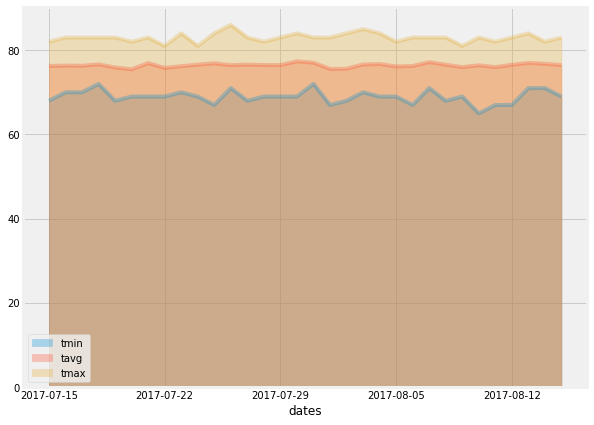

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_normals.plot(kind='area', stacked=False, alpha=0.3) #, colormap='Reds')
plt.gcf().set_size_inches(9,7)

plt.show()
